In [12]:
import pandas as pd
import numpy as np

# 1. Cargar el archivo de promedios
file_path = "exportados/Robos a negocios/cuadrantes_robos_negocios_promedio.xlsx"
df_promedios = pd.read_excel(file_path)

# Renombrar columnas para facilitar el manejo
column_names = {
    'CUADRANTE': 'CUADRANTE',
    'POBLACION': 'POBLACION'
}
for i in range(1, 13):
    column_names[f'PROMEDIO DE ROBOS A NEGOCIOS MES {i}'] = f'ROBOS_MES_{i}'

df_promedios.rename(columns=column_names, inplace=True)

# 2. Desapilar (Unpivot) la tabla para crear las 936 filas
# La columna 'POBLACION' se mantiene fija para cada cuadrante.
df_long = df_promedios.melt(
    id_vars=['CUADRANTE', 'POBLACION'],
    value_vars=[f'ROBOS_MES_{i}' for i in range(1, 13)],
    var_name='MES_NOMBRE',
    value_name='ROBOS_MES_N' # Este es el valor que queremos predecir (Y)
)

# 3. Extraer el número de mes (MES_N)
df_long['MES_N'] = df_long['MES_NOMBRE'].str.extract(r'(\d+)').astype(int)
df_long.drop(columns=['MES_NOMBRE'], inplace=True)

# 4. Ordenar la tabla por CUADRANTE y MES_N
df_long.sort_values(by=['MES_N', 'CUADRANTE'], inplace=True)
df_long.reset_index(drop=True, inplace=True)

print("### 1. DataFrame de 936 Filas (Formato de Serie de Tiempo) ###")
print(df_long.head(80).tail(5)) # Muestra los últimos del Mes 1
print(f"\nTotal de filas: {len(df_long)}")
print("-" * 50)

### 1. DataFrame de 936 Filas (Formato de Serie de Tiempo) ###
    CUADRANTE  POBLACION  ROBOS_MES_N  MES_N
75         76      15331     0.454545      1
76         77      13950     2.454545      1
77         78      12572     0.545455      1
78          1          0     0.181818      2
79          2          0     0.000000      2

Total de filas: 936
--------------------------------------------------


In [20]:
# 5. Crear la columna de Diciembre (MES 12) para usarla como N-1 del Mes 1
# Extraer los promedios de Diciembre (MES 12)
df_diciembre = df_long[df_long['MES_N'] == 12].copy()
df_diciembre.rename(columns={'ROBOS_MES_N': 'ROBOS_DIC'}, inplace=True)
df_diciembre = df_diciembre[['CUADRANTE', 'ROBOS_DIC']]

# Extraer los promedios de Noviembre (MES 11)
df_noviembre = df_long[df_long['MES_N'] == 11].copy()
df_noviembre.rename(columns={'ROBOS_MES_N': 'ROBOS_NOV'}, inplace=True)
df_noviembre = df_noviembre[['CUADRANTE', 'ROBOS_NOV']]

# 6. Crear las columnas N-1 y N-2 usando 'shift' agrupado
df_long['ROBOS_MES_N_MENOS_1'] = df_long.groupby('CUADRANTE')['ROBOS_MES_N'].shift(1)
df_long['ROBOS_MES_N_MENOS_2'] = df_long.groupby('CUADRANTE')['ROBOS_MES_N'].shift(2)

# 7. Imputar Enero (MES_N = 1 y 2) con los valores de Diciembre y Noviembre
# El Mes 1 (Enero) toma N-1 de Diciembre y N-2 de Noviembre.
df_long = df_long.merge(df_diciembre, on='CUADRANTE', how='left')
df_long.loc[df_long['MES_N'] == 1, 'ROBOS_MES_N_MENOS_1'] = df_long.loc[df_long['MES_N'] == 1, 'ROBOS_DIC']

df_long = df_long.merge(df_noviembre, on='CUADRANTE', how='left')
df_long.loc[df_long['MES_N'] == 1, 'ROBOS_MES_N_MENOS_2'] = df_long.loc[df_long['MES_N'] == 1, 'ROBOS_NOV']

# El Mes 2 (Febrero) toma N-2 de Diciembre
df_long.loc[df_long['MES_N'] == 2, 'ROBOS_MES_N_MENOS_2'] = df_long.loc[df_long['MES_N'] == 2, 'ROBOS_DIC']

df_final = df_long.drop(columns=['ROBOS_DIC', 'ROBOS_NOV'])

print("### 2. DataFrame Final con Variables N-1 y N-2 (Primeros 5 cuadrantes) ###")
print(df_final.head(5))
print("-" * 50)

KeyError: 'ROBOS_DIC'

In [21]:
# exportar el DataFrame final df.final a un archivo Excel
# output_file_path = "exportados/serie_tiempo_robos_negocios.xlsx"
# df_final.to_excel(output_file_path, index=False)
# print(f"DataFrame final exportado a: {output_file_path}")

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler # <-- para normalizar

# 1. Separar la tabla para aplicar el escalador
df_scale = df_final[['CUADRANTE', 'POBLACION', 'ROBOS_MES_N_MENOS_1', 'ROBOS_MES_N_MENOS_2', 'ROBOS_MES_N']].copy()

# 2. Aplicar el escalador (entrenado SOLO con los datos de entrada X)
# El escalador debe tratar todas las variables por separado
scaler = MinMaxScaler()
df_scaled_values = scaler.fit_transform(df_scale)
df_scaled = pd.DataFrame(df_scaled_values, columns=df_scale.columns)
df_scaled['MES_N'] = df_final['MES_N'].values # Añadir el MES_N de vuelta

# 3. Estructurar X y Y para Keras (Múltiples Salidas) con datos escalados
X_features_scaled = df_scaled[['CUADRANTE', 'POBLACION', 'ROBOS_MES_N_MENOS_1', 'ROBOS_MES_N_MENOS_2']]
Y_output_scaled = df_scaled['ROBOS_MES_N']

# Agrupar los datos escalados
X_data_scaled = X_features_scaled.groupby(df_scaled['MES_N']).apply(lambda x: x.values.flatten()).tolist()
Y_data_scaled = Y_output_scaled.groupby(df_scaled['MES_N']).apply(lambda x: x.values).tolist()

X_scaled = np.array(X_data_scaled)
Y_scaled = np.array(Y_data_scaled)

# Dividir para entrenamiento y prueba (mantenemos test_size=0.15 por ahora)
X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled = train_test_split(
    X_scaled, Y_scaled, test_size=0.15, shuffle=False
)

input_dim = X_scaled.shape[1]
output_dim = Y_scaled.shape[1]

# 4. Reconstruir y Entrenar el Modelo Keras (con datos escalados)
# Se reduce la tasa de aprendizaje (learning rate) como medida de precaución adicional
model_scaled = Sequential([
    Dense(512, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(output_dim, activation='linear')
])

model_scaled.compile(optimizer=Adam(learning_rate=0.0005), loss='mse') # Reducción de LR
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("### Entrenamiento del Modelo Keras (Datos Normalizados) ###")
model_scaled.fit(
    X_train_scaled, Y_train_scaled,
    epochs=200, # Aumentamos épocas por si acaso
    batch_size=2,
    validation_data=(X_test_scaled, Y_test_scaled),
    callbacks=[early_stop],
    verbose=0
)
print("Entrenamiento con normalización finalizado.")

# 5. Evaluación (R^2)
Y_pred_test_scaled = model_scaled.predict(X_test_scaled)
r2_scaled = r2_score(Y_test_scaled.flatten(), Y_pred_test_scaled.flatten())

print(f"\n### Coeficiente de Determinación (R^2) con Normalización: {r2_scaled:.4f} ###")

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Entrenamiento del Modelo Keras (Datos Normalizados) ###
Entrenamiento con normalización finalizado.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

### Coeficiente de Determinación (R^2) con Normalización: 0.9048 ###


# Para predecir un mes, el top 10 de cuadrantes

In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error


def predecir_y_evaluar_top_cuadrantes(mes_a_predecir, df_historico, modelo, escalador, df_datos_reales):
    """
    Predice y evalúa el robo promedio a negocios para los 78 cuadrantes en un mes N.

    Args:
        mes_a_predecir (int): El número del mes que se quiere predecir (ej. 13).
        df_historico (pd.DataFrame): El DataFrame con los promedios históricos (df_final).
        modelo (tf.keras.Model): El modelo de Keras entrenado (model_scaled).
        escalador (sklearn.preprocessing.MinMaxScaler): El objeto MinMaxScaler.
        df_datos_reales (pd.DataFrame): DataFrame con la columna 'ROBOS_MES_N' real para ese mes N.

    Returns:
        tuple: (DataFrame del Top 10, R2, MAE)
    """

    print(f"--- Ejecutando Predicción y Evaluación para el Mes {mes_a_predecir} ---")

    # 1. Definir meses históricos cíclicos
    mes_n_menos_1 = (mes_a_predecir - 1)
    mes_n_menos_2 = (mes_a_predecir - 2)
    mes_anterior_ciclo = (mes_n_menos_1 - 1) % 12 + 1
    mes_anterior_2_ciclo = (mes_n_menos_2 - 1) % 12 + 1

    # 2. Obtener los 78 datos de entrada de los meses N-1 y N-2
    df_n_menos_1 = df_historico[df_historico['MES_N'] == mes_anterior_ciclo].copy()
    df_n_menos_2 = df_historico[df_historico['MES_N'] == mes_anterior_2_ciclo].copy()

    # 3. Construir el DataFrame de Entrada (78 filas)
    df_prediccion = df_historico[df_historico['MES_N'] == 1].copy()

    # Asegurar orden y rellenar las columnas de entrada
    df_prediccion.sort_values(by='CUADRANTE', inplace=True)
    df_n_menos_1.sort_values(by='CUADRANTE', inplace=True)
    df_n_menos_2.sort_values(by='CUADRANTE', inplace=True)

    df_prediccion['ROBOS_MES_N_MENOS_1'] = df_n_menos_1['ROBOS_MES_N'].values
    df_prediccion['ROBOS_MES_N_MENOS_2'] = df_n_menos_2['ROBOS_MES_N'].values

    # 4. Preparar, Escalar y Aplanar la matriz X (312 entradas)
    X_pred_raw = df_prediccion[['CUADRANTE', 'POBLACION', 'ROBOS_MES_N_MENOS_1', 'ROBOS_MES_N_MENOS_2']].values
    X_con_dummy = np.hstack((X_pred_raw, np.zeros((X_pred_raw.shape[0], 1))))
    X_pred_escalado_completo = escalador.transform(X_con_dummy)
    X_pred_final = X_pred_escalado_completo[:, :4].flatten().reshape(1, -1)

    # 5. Realizar la Predicción (Y_pred_scaled)
    Y_pred_scaled = modelo.predict(X_pred_final)

    # 6. Desescalar la Predicción (Y_pred_desescalado)
    Y_pred_full = np.hstack((X_pred_raw, Y_pred_scaled.T))
    Y_pred_desescalado = escalador.inverse_transform(Y_pred_full)[:, -1]

    # 7. Generar el Top N (DataFrame de resultados)
    df_resultado = pd.DataFrame({
        'CUADRANTE': df_prediccion['CUADRANTE'].values,
        'PREDICCION_ROBOS_MES_N': Y_pred_desescalado,
        'MES_PREDICHO': mes_a_predecir
    })

    # 8. EVALUACIÓN Y COMPARACIÓN con Datos Reales
    # Aseguramos que el orden de los datos reales coincida con la predicción (por CUADRANTE)
    df_datos_reales.sort_values(by='CUADRANTE', inplace=True)
    Y_real = df_datos_reales['ROBOS_MES_N'].values

    # Unir predicción y real para la visualización del Top N
    df_resultado['ROBOS_REALES_MES_N'] = Y_real

    # Cálculo de Métricas
    r2 = r2_score(Y_real, Y_pred_desescalado)
    mae = mean_absolute_error(Y_real, Y_pred_desescalado)

    # Generar Top 10 con la comparación
    top_10 = df_resultado.sort_values(by='PREDICCION_ROBOS_MES_N', ascending=False).head(10).round(2)

    return top_10, r2, mae

# Para predecir un solo cuadrante y un solo mes

In [24]:
import pandas as pd
import numpy as np

# ASUME que 'scaler' y 'model_scaled' ya están definidos y entrenados en el notebook.

def predecir_cuadrante_individual(cuadrante_n, poblacion, robos_n_menos_1, robos_n_menos_2, scaler, model_nn_variable):
    """
    Realiza una predicción individual de robos para un cuadrante específico.

    Args:
        cuadrante_n (int): Número del cuadrante.
        poblacion (int): Población del cuadrante.
        robos_n_menos_1 (float): Robos promedio del mes N-1.
        robos_n_menos_2 (float): Robos promedio del mes N-2.
        scaler (MinMaxScaler): El scaler ajustado usado durante el entrenamiento.
        model_nn_variable (keras.Model): El modelo de Red Neuronal entrenado (model_scaled).

    Returns:
        float: El número de robos predicho para el mes N.
    """
    
    # 1. Crear el DataFrame de entrada con las mismas columnas que el entrenamiento
    # Es crucial que las columnas y el orden sean IDÉNTICOS a X_train
    datos_entrada = pd.DataFrame({
        'CUADRANTE': [cuadrante_n],
        'POBLACION': [poblacion],
        'ROBOS_MES_N_MENOS_1': [robos_n_menos_1],
        'ROBOS_MES_N_MENOS_2': [robos_n_menos_2]
    })
    
    # 2. Normalizar los datos de entrada
    X_pred_escalado = scaler.transform(datos_entrada)
    
    # 3. Realizar la predicción
    # Se usa el modelo con el nombre de la variable corregida
    pred_escalada = model_nn_variable.predict(X_pred_escalado, verbose=0)
    
    # 4. Desescalar la predicción (mismo procedimiento)
    # Suponemos que Y (ROBOS_MES_N) es la última columna del dataset completo.
    pred_placeholder = np.zeros(shape=(len(datos_entrada), scaler.n_features_in_))
    pred_placeholder[:, -1] = pred_escalada.flatten()
    
    # Aplicar la desescalación inversa
    pred_desescalada = scaler.inverse_transform(pred_placeholder)[:, -1]
    
    return pred_desescalada[0]

In [25]:
# --- DATOS DE ENTRADA PARA LA PREDICCIÓN (EJEMPLO) ---

CUADRANTE_A_PREDECIR = 16
POBLACION_CUADRANTE = 12090  # Usa la población real
ROBOS_MES_N_MENOS_1 = 2.63 
ROBOS_MES_N_MENOS_2 = 2.09

# --- EJECUCIÓN (ASUMIENDO que 'scaler' y 'model_scaled' existen) ---

try:
    prediccion_final = predecir_cuadrante_individual(
        CUADRANTE_A_PREDECIR, 
        POBLACION_CUADRANTE, 
        ROBOS_MES_N_MENOS_1, 
        ROBOS_MES_N_MENOS_2, 
        scaler, 
        model_scaled # ¡VARIABLE CORREGIDA!
    )

    print(f"### Predicción de Robos para Cuadrante {CUADRANTE_A_PREDECIR} (Mes N) ###")
    print("-" * 45)
    print(f"➡️ Predicción del Modelo: {prediccion_final:.2f} robos promedio")

except NameError as e:
    print("⚠️ Error: Asegúrate de haber ejecutado las celdas de entrenamiento ('model_scaled' y 'scaler') primero.")

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- ROBOS_MES_N


In [19]:
# --- DATOS DE ENTRADA PARA LA PREDICCIÓN (EJEMPLO) ---

# Queremos predecir el Mes N para el Cuadrante 37 (uno de los top)
CUADRANTE_A_PREDECIR = 16
POBLACION_CUADRANTE = 12090  # Usa la población real de tu tabla

# Datos históricos que usaría Mes N-1 y Mes N-2
ROBOS_MES_N_MENOS_1 = 2.63 # Ejemplo: Robos promedio del mes pasado
ROBOS_MES_N_MENOS_2 = 2.09 # Ejemplo: Robos promedio de hace dos meses

# --- EJECUCIÓN ---

# ASUMIMOS que el 'scaler' y 'modelo_nn' están disponibles en la memoria
try:
    prediccion_final = predecir_cuadrante_individual(
        CUADRANTE_A_PREDECIR, 
        POBLACION_CUADRANTE, 
        ROBOS_MES_N_MENOS_1, 
        ROBOS_MES_N_MENOS_2, 
        scaler, 
        model_scaled
    )

    print(f"### Predicción de Robos para Cuadrante {CUADRANTE_A_PREDECIR} (Mes N) ###")
    print(f"Robos N-1: {ROBOS_MES_N_MENOS_1}")
    print(f"Robos N-2: {ROBOS_MES_N_MENOS_2}")
    print("-" * 45)
    print(f"➡️ Predicción del Modelo: {prediccion_final:.2f} robos promedio")

except NameError as e:
    print("⚠️ Error: Asegúrate de haber ejecutado las celdas de entrenamiento primero.")
    print(f"El error es: {e}")

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- ROBOS_MES_N


# Predicción para el mes de enero

In [26]:
## ----------------------------------------------------------------------
# USO Y RESULTADO
# ----------------------------------------------------------------------

# --- SIMULACIÓN DE DATOS REALES DE UN MES (Mes 13 = Enero) ---
# En un escenario real, df_datos_reales serían 78 filas con los robos reales de Enero.
# Para la simulación, usaremos los robos promedio de Enero (MES 1) de tu histórico como si fueran los "reales". Esto se puede cambiar para poder predecir cualquier otro mes, del 13 al 24.
df_enero_real = df_final[df_final['MES_N'] == 1][['CUADRANTE', 'ROBOS_MES_N']].copy()
df_enero_real.rename(columns={'ROBOS_MES_N': 'ROBOS_MES_N_REAL'}, inplace=True)

top_10_prediccion_enero, r2_final_enero, mae_final_enero = predecir_y_evaluar_top_cuadrantes(
    mes_a_predecir=13, # El mes que estamos prediciendo
    df_historico=df_final,
    modelo=model_scaled,
    escalador=scaler,
    df_datos_reales=df_enero_real.rename(columns={'ROBOS_MES_N_REAL': 'ROBOS_MES_N'}) # Se debe llamar ROBOS_MES_N
)

print("\n### RESULTADOS DE PREDICCIÓN Y EVALUACIÓN ###")
print(f"R² del Mes Predicho vs. Mes Real: {r2_final_enero:.4f}")
print(f"Error Absoluto Medio (MAE): {mae_final_enero:.4f} (Robos de diferencia promedio)")
print("\nTOP 10 CUADRANTES CON PREDICCIÓN Y REAL COMPARADO:")
print(top_10_prediccion_enero)

--- Ejecutando Predicción y Evaluación para el Mes 13 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

### RESULTADOS DE PREDICCIÓN Y EVALUACIÓN ###
R² del Mes Predicho vs. Mes Real: 0.9116
Error Absoluto Medio (MAE): 0.2768 (Robos de diferencia promedio)

TOP 10 CUADRANTES CON PREDICCIÓN Y REAL COMPARADO:
    CUADRANTE  PREDICCION_ROBOS_MES_N  MES_PREDICHO  ROBOS_REALES_MES_N
36         37                    3.94            13                4.91
12         13                    3.85            13                4.64
54         55                    3.83            13                4.73
24         25                    3.80            13                4.45
30         31                    3.32            13                3.82
7           8                    3.31            13                3.64
69         70                    3.20            13                4.00
23         24                    3.13            13                3.64
6           7                    2.84            1

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [27]:
# Cargar datos de robos principales para obtener coordenadas
df_robos = pd.read_csv('robos_tot_final.csv')

# Obtener coordenadas promedio por cuadrante
cuadrante_coords = df_robos.groupby('CUADRANTE')[['LATITUD', 'LONGITUD', 'DISTRITO']].agg({
    'LATITUD': 'mean',
    'LONGITUD': 'mean',
    'DISTRITO': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
}).reset_index()

# Agregar coordenadas al top 10
df_resultado_final = top_10_prediccion_enero.merge(cuadrante_coords, on='CUADRANTE', how='left')
df_resultado_final = df_resultado_final[['CUADRANTE', 'PREDICCION_ROBOS_MES_N', 'LATITUD', 'LONGITUD', 'DISTRITO']]
print(df_resultado_final)

# EXPORTAR A CSV
output_file_path_final = "exportados/Robos a negocios/top_10_prediccion_robos_negocios_enero.csv"
df_resultado_final.to_csv(output_file_path_final, index=False)
print(f"\nDataFrame final exportado a: {output_file_path_final}")

   CUADRANTE  PREDICCION_ROBOS_MES_N    LATITUD    LONGITUD DISTRITO
0         37                    3.94  28.637885 -106.078318    Ángel
1         13                    3.85  28.725755 -106.120496    Colón
2         55                    3.83  28.608225 -106.027893  Morelos
3         25                    3.80  28.651471 -106.086900    Villa
4         31                    3.32  28.645882 -106.109430    Diana
5          8                    3.31  28.742114 -106.125641    Colón
6         70                    3.20  28.623247 -106.060150   Zapata
7         24                    3.13  28.678091 -106.092866    Villa
8          7                    2.84  28.740339 -106.138101    Colón
9         77                    2.76  28.617795 -106.035884   Zapata

DataFrame final exportado a: exportados/Robos a negocios/top_10_prediccion_robos_negocios_enero.csv


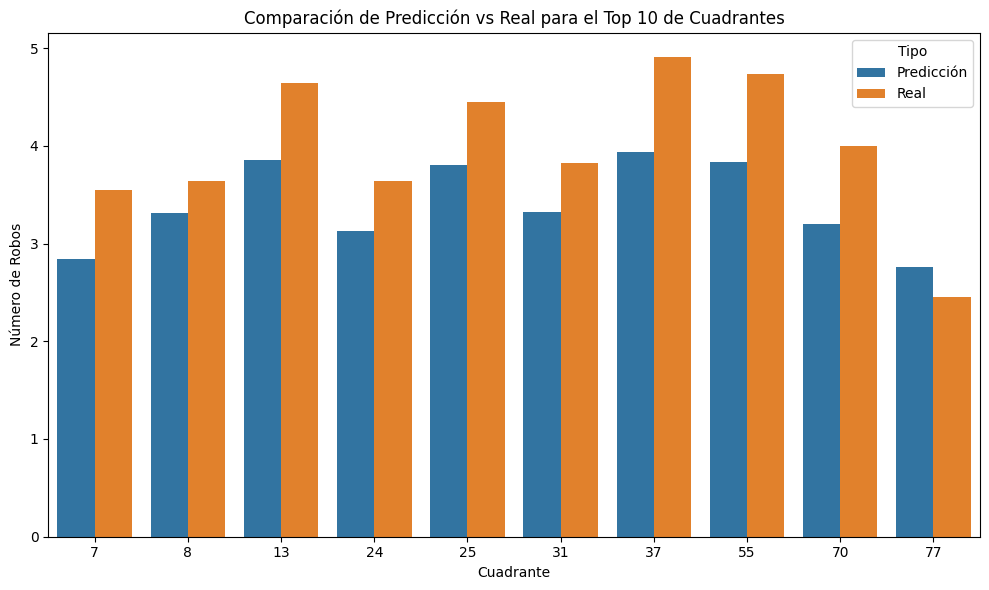

In [28]:
# graficar predicción vs real por cuadrante
import matplotlib.pyplot as plt
import seaborn as sns
# Preparar datos para graficar
df_grafico = top_10_prediccion_enero.melt(id_vars=['CUADRANTE'], 
                                    value_vars=['PREDICCION_ROBOS_MES_N', 'ROBOS_REALES_MES_N'], 
                                    var_name='Tipo', value_name='Robos')
# Asegurar orden consistente de categorías (opcional pero útil)
df_grafico['Tipo'] = pd.Categorical(df_grafico['Tipo'], categories=['PREDICCION_ROBOS_MES_N', 'ROBOS_REALES_MES_N'])
# Crear la gráfica con paleta explícita y conservar handles para la leyenda
plt.figure(figsize=(10, 6))
palette = ['#1f77b4', '#ff7f0e']  # azul y naranja (puedes cambiar los hex)
ax = sns.barplot(data=df_grafico, x='CUADRANTE', y='Robos', hue='Tipo', palette=palette)
ax.set_title('Comparación de Predicción vs Real para el Top 10 de Cuadrantes')
ax.set_xlabel('Cuadrante')
ax.set_ylabel('Número de Robos')
# Obtener handles y labels generados por seaborn y reemplazar las etiquetas por español
handles, labels = ax.get_legend_handles_labels()
ax.legend(title='Tipo', handles=handles, labels=['Predicción', 'Real'])
plt.tight_layout()
plt.show()

# Predicción para el mes de febrero

In [29]:
## ----------------------------------------------------------------------
# USO Y RESULTADO
# ----------------------------------------------------------------------

# --- SIMULACIÓN DE DATOS REALES DE UN MES (Mes 14 = Febrero) ---
# En un escenario real, df_datos_reales serían 78 filas con los robos reales de Febrero.
# Para la simulación, usaremos los robos promedio de Febrero (MES 2) de tu histórico como si fueran los "reales". Esto se puede cambiar para poder predecir cualquier otro mes, del 13 al 24.
df_febrero_real = df_final[df_final['MES_N'] == 2][['CUADRANTE', 'ROBOS_MES_N']].copy()
df_febrero_real.rename(columns={'ROBOS_MES_N': 'ROBOS_MES_N_REAL'}, inplace=True)

top_10_prediccion_febrero, r2_final_febrero, mae_final_febrero = predecir_y_evaluar_top_cuadrantes(
    mes_a_predecir=14, # El mes que estamos prediciendo
    df_historico=df_final,
    modelo=model_scaled,
    escalador=scaler,
    df_datos_reales=df_febrero_real.rename(columns={'ROBOS_MES_N_REAL': 'ROBOS_MES_N'}) # Se debe llamar ROBOS_MES_N
)

print("\n### RESULTADOS DE PREDICCIÓN Y EVALUACIÓN ###")
print(f"R² del Mes Predicho vs. Mes Real: {r2_final_febrero:.4f}")
print(f"Error Absoluto Medio (MAE): {mae_final_febrero:.4f} (Robos de diferencia promedio)")
print("\nTOP 10 CUADRANTES CON PREDICCIÓN Y REAL COMPARADO:")
print(top_10_prediccion_febrero)

--- Ejecutando Predicción y Evaluación para el Mes 14 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

### RESULTADOS DE PREDICCIÓN Y EVALUACIÓN ###
R² del Mes Predicho vs. Mes Real: 0.8729
Error Absoluto Medio (MAE): 0.3535 (Robos de diferencia promedio)

TOP 10 CUADRANTES CON PREDICCIÓN Y REAL COMPARADO:
    CUADRANTE  PREDICCION_ROBOS_MES_N  MES_PREDICHO  ROBOS_REALES_MES_N
36         37                    4.30            14                4.91
54         55                    4.06            14                4.45
24         25                    4.06            14                4.73
12         13                    3.99            14                4.36
30         31                    3.61            14                5.09
7           8                    3.48            14                4.18
23         24                    3.29            14                3.55
69         70                    3.24            14                3.91
6           

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


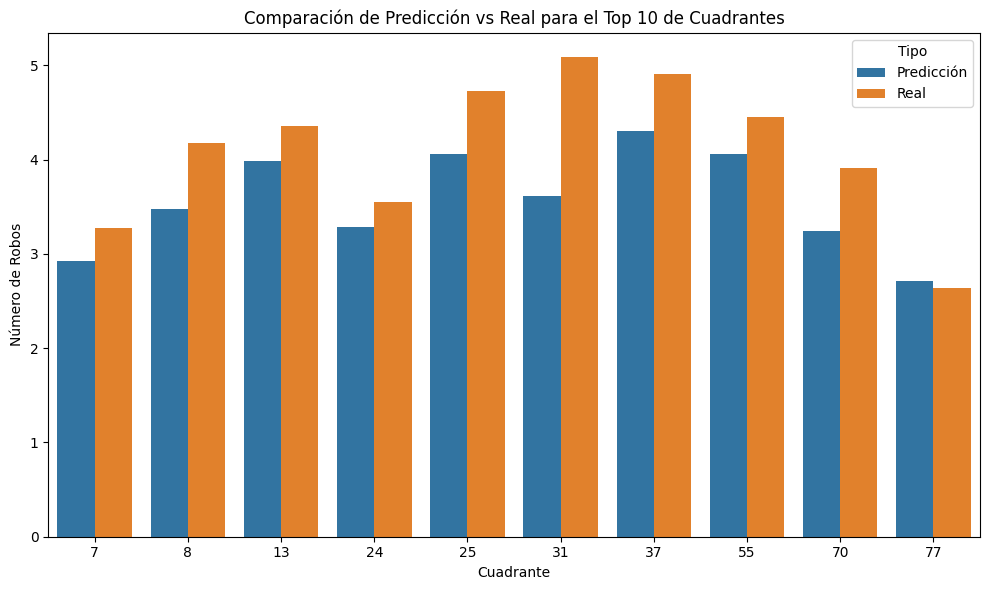

In [30]:
# graficar predicción vs real por cuadrante
import matplotlib.pyplot as plt
import seaborn as sns
# Preparar datos para graficar
df_grafico = top_10_prediccion_febrero.melt(id_vars=['CUADRANTE'], 
                                    value_vars=['PREDICCION_ROBOS_MES_N', 'ROBOS_REALES_MES_N'], 
                                    var_name='Tipo', value_name='Robos')
# Asegurar orden consistente de categorías (opcional pero útil)
df_grafico['Tipo'] = pd.Categorical(df_grafico['Tipo'], categories=['PREDICCION_ROBOS_MES_N', 'ROBOS_REALES_MES_N'])
# Crear la gráfica con paleta explícita y conservar handles para la leyenda
plt.figure(figsize=(10, 6))
palette = ['#1f77b4', '#ff7f0e']  # azul y naranja (puedes cambiar los hex)
ax = sns.barplot(data=df_grafico, x='CUADRANTE', y='Robos', hue='Tipo', palette=palette)
ax.set_title('Comparación de Predicción vs Real para el Top 10 de Cuadrantes')
ax.set_xlabel('Cuadrante')
ax.set_ylabel('Número de Robos')
# Obtener handles y labels generados por seaborn y reemplazar las etiquetas por español
handles, labels = ax.get_legend_handles_labels()
ax.legend(title='Tipo', handles=handles, labels=['Predicción', 'Real'])
plt.tight_layout()
plt.show()